# MNS - Biological Plausible Deep Learning

In [1]:
!pip install -r requirements.txt --quiet

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [6]:
# Import Packages
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Import Network Architectures
from DNN import DNN, train_dnn_model, get_test_error, eval_dnn
from CNN import CNN, train_cnn_model

# Import log-helper/learning plot functions
from helpers import *
from logger import get_latest_log_fname, process_logger

# Import Bayesian Optimization Module
from bayesian_opt import BO_DNN

In [7]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print("Torch Device: {}".format(torch.cuda.get_device_name(0)))
else:
    print("Torch Device: Local CPU")
    
# Remove files in log dir
log_dir = os.getcwd() + "/logs"
if not os.path.exists(log_dir):
    os.makedirs(directory)
    print("Created New Log Directory")
else:
    filelist = [ f for f in os.listdir(log_dir) if f.endswith(".bak") ]
    for f in filelist:
        os.remove(os.path.join(mydir, f))
    print("Deleted Old Files in Existing Log Directory")

Torch Device: Local CPU
Deleted Old Files in Existing Log Directory


# CIFAR10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='../../data', 
                                             train=True, 
                                             transform=transforms.ToTensor(),  
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data', 
                                            train=False, 
                                            transform=transforms.ToTensor())

# Simple Feedforward Neural Net

In [8]:
# MNIST dataset
X, y = get_data(num_samples=70000)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    random_state=0)

# Define batchsize for data-loading/Epochs for training
batch_size = 100
num_epochs = 5
learning_rate = 0.001

# Instantiate the model with layersize and Logging directory
dnn_model = DNN(h_sizes=[784, 500], out_size=10)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dnn_model.parameters(), lr=learning_rate)

/Users/rtl/anaconda2/envs/mns-project/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/Users/rtl/anaconda2/envs/mns-project/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


In [9]:
model = train_dnn_model(dnn_model, num_epochs,
                        X, y, batch_size,
                        device, optimizer, criterion,
                        model_fname ="models/temp_model_dnn.ckpt",
                        verbose=True, logging=True)

# Get test error
score = get_test_error(device, model, X_test, y_test)
print("Test Accuracy: {}".format(score))

train | epoch  1 | acc: 0.9079 | loss: 0.3252 | time: 3.05
valid | epoch  1 | acc: 0.9513 | loss: 0.1630 | time: 0.31
--------------------------------------------------
train | epoch  2 | acc: 0.9636 | loss: 0.1234 | time: 3.78
valid | epoch  2 | acc: 0.9676 | loss: 0.1122 | time: 0.25
--------------------------------------------------
train | epoch  3 | acc: 0.9762 | loss: 0.0809 | time: 3.67
valid | epoch  3 | acc: 0.9715 | loss: 0.0938 | time: 0.24
--------------------------------------------------
train | epoch  4 | acc: 0.9832 | loss: 0.0570 | time: 3.71
valid | epoch  4 | acc: 0.9739 | loss: 0.0846 | time: 0.25
--------------------------------------------------
train | epoch  5 | acc: 0.9884 | loss: 0.0409 | time: 3.73
valid | epoch  5 | acc: 0.9758 | loss: 0.0799 | time: 0.24
--------------------------------------------------
Test Accuracy: 0.987542857143


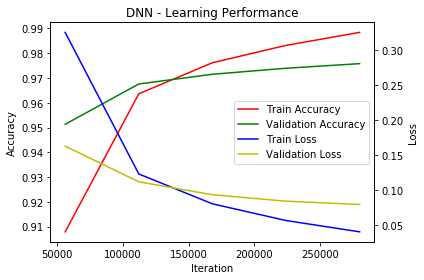

In [10]:
log_fname = get_latest_log_fname(log_dir)
its, train_loss, val_loss, train_acc, val_acc = process_logger(log_fname)
plot_learning(its, train_acc, val_acc, train_loss, val_loss, "DNN - Learning Performance")

In [11]:
eval_dnn(batch_size, learning_rate,
         num_layers=1, h_l_1=500,
         k_fold=3, verbose=True)

Batchsize: 100
Learning Rate: 0.001
Architecture of Cross-Validated Network:
	 Layer 0: 784 Units
	 Layer 1: 500 Units


/Users/rtl/anaconda2/envs/mns-project/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/Users/rtl/anaconda2/envs/mns-project/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


Cross-Validation Score Fold 1: 0.97141755228
Cross-Validation Score Fold 2: 0.971756739382
Cross-Validation Score Fold 3: 0.973468775449


0.9722143557035681

In [14]:
hyper_space_dnn = {'batch_size': (10, 500),
                   'learning_rate': (0.0001, 0.05),
                   'num_layers': (1, 6),
                   'h_l_1': (30, 500),
                   'h_l_2': (30, 500),
                   'h_l_3': (30, 500),
                   'h_l_4': (30, 500),
                   'h_l_5': (30, 500),
                   'h_l_6': (30, 500)}

BO_NN(3, eval_dnn, hyper_space_dnn)

(0.9478993942957041, {'h_l_1': 369, 'h_l_3': 172, 'h_l_2': 30, 'h_l_5': 73, 'h_l_4': 99, 'batch_size': 214, 'h_l_6': 118, 'num_layers': 3, 'learning_rate': 0.01734348027944808})
(0.9508577310087379, {'h_l_1': 191, 'h_l_3': 179, 'h_l_2': 58, 'h_l_5': 156, 'h_l_4': 150, 'batch_size': 162, 'h_l_6': 380, 'num_layers': 4, 'learning_rate': 0.010203485503870131})
(0.9072285378347232, {'h_l_1': 475, 'h_l_3': 497, 'h_l_2': 368, 'h_l_5': 496, 'h_l_4': 497, 'batch_size': 488, 'h_l_6': 486, 'num_layers': 2, 'learning_rate': 0.04782025888977568})


# Simple Convolutional Neural Network

In [ ]:
# ConvNet Parameters
ch_sizes = [1, 16, 32]
k_sizes = [5, 5]
stride = 1
padding = 2
out_size = 10
num_epochs = 5
learning_rate = 0.001

# Instantiate the model with layersizes, Loss fct, optimizer
cnn_model = CNN(ch_sizes, k_sizes,
                stride, padding, out_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)

In [ ]:
train_cnn_model(cnn_model, num_epochs,
                train_loader, test_loader,
                device, optimizer, criterion,
                model_fname ="models/temp_model_cnn.ckpt",
                verbose=True, logging=True)

## Guergiev et al (2017)

In [ ]:
import comp_dl as dl

# silence 80% of feedback weights
dl.use_sparse_feedback = True

# set training parameters
f_etas = (0.21, 0.21)
b_etas = None
n_epochs = 10
n_training_examples = 60000

# create the network -- this will also load the MNIST dataset files
net = dl.Network(n=(500, 10))

# train the network
net.train(f_etas, b_etas, n_epochs,
          n_training_examples, save_simulation=True,
          simulations_folder="Simulations",
          folder_name="Example Simulation")

# re-load the saved simulation & network
net, f_etas, b_etas, n_training_examples = dl.load_simulation(latest_epoch=9, folder_name="Example Simulation", simulations_folder="Simulations")

# train the network for another 10 epochs
net.train(f_etas, b_etas, n_epochs, n_training_examples, save_simulation=True, simulations_folder="Simulations", folder_name="Example Simulation")

In [ ]:
nonspiking_mode         = True  # whether to run in non-spiking mode (real-valued outputs)
use_rand_phase_lengths  = True  # use random phase lengths (chosen from Wald distribution)
use_rand_plateau_times  = False # randomly sample the time of each neuron's apical plateau potential
use_conductances        = True  # use conductances between dendrites and soma
use_broadcast           = True  # use broadcast (ie. feedback to all layers comes from output layer)
use_spiking_feedback    = True  # use spiking feedback
use_spiking_feedforward = True  # use spiking feedforward input

use_symmetric_weights   = False # enforce symmetric weights
noisy_symmetric_weights = False # add noise to symmetric weights

use_sparse_feedback     = False # use sparse feedback weights
update_feedback_weights = False # update feedback weights
use_backprop            = False # use error backpropagation
use_apical_conductance  = False # use attenuated conductance from apical dendrite to soma
use_weight_optimization = True  # attempt to optimize initial weights
use_feedback_bias       = False # use biases in feedback paths
initial_test            = False # whether to do an initial test on the test set prior to training

record_backprop_angle   = False # record angle b/w hidden layer error signals and backprop-generated error signals
record_loss             = True  # record final layer loss during training
record_training_error   = True  # record training error during training
record_training_labels  = True  # record labels of images that were shown during training
record_phase_times      = False # record phase transition times across training
record_plateau_times    = False # record plateau potential times for each neuron across training
record_voltages         = False # record voltages of neurons during training (huge arrays for long simulations!)

# --- Jacobian testing --- #
record_eigvals          = False # record maximum eigenvalues for Jacobians
record_matrices         = False # record Jacobian product & weight product matrices (huge arrays for long simulations!)
plot_eigvals            = False # dynamically plot maximum eigenvalues for Jacobians

default_simulations_folder = 'Simulations/' # folder in which to save simulations (edit accordingly)
weight_cmap                = 'bone'         # color map to use for weight plotting

dt  = 1.0        # time step (ms)
mem = int(10/dt) # spike memory (time steps) - used to limit PSP integration of past spikes (for performance)

l_f_phase      = int(50/dt)  # length of forward phase (time steps)
l_t_phase      = int(50/dt)  # length of target phase (time steps)
l_f_phase_test = int(250/dt) # length of forward phase for tests (time steps)

integration_time      = l_f_phase - int(30/dt)      # time steps of integration of neuronal variables used for plasticity
integration_time_test = l_f_phase_test - int(30/dt) # time steps of integration of neuronal variables during testing

# 2nd set of hyperparameters
lambda_max = 0.2*dt # maximum spike rate (spikes per time step)

# kernel parameters
tau_s = 3.0  # synaptic time constant
tau_L = 10.0 # leak time constant

# conductance parameters
g_B = 0.6                                   # basal conductance
g_A = 0.05 if use_apical_conductance else 0 # apical conductance
g_L = 1.0/tau_L                             # leak conductance
g_D = g_B                                   # dendritic conductance in output layer

E_E = 8  # excitation reversal potential
E_I = -8 # inhibition reversal potential

# steady state constants
k_B = g_B/(g_L + g_B + g_A)
k_D = g_D/(g_L + g_D)
k_I = 1.0/(g_L + g_D)

# weight update constants
P_hidden = 20.0/lambda_max      # hidden layer error signal scaling factor
P_final  = 20.0/(lambda_max**2) # final layer error signal scaling factor

In [ ]:
if nonspiking_mode:
    # set parameters for non-spiking mode
    use_rand_phase_lengths  = False
    use_rand_plateau_times  = False
    use_conductances        = False
    use_spiking_feedforward = False
    use_spiking_feedback    = False
    record_phase_times      = False
    record_plateau_times    = False
    record_voltages         = False

    l_f_phase             = 2
    l_t_phase             = 2
    l_f_phase_test        = 2
    integration_time      = 1
    integration_time_test = 1
    mem                   = 1

In [ ]:
if use_rand_phase_lengths:
    # set minimum phase lengths
    min_l_f_phase = l_f_phase
    min_l_t_phase = l_t_phase